# Finance Data OS — Week 4 Notebook
Signals to Toy Backtest to Parquet Exports for Power BI

This notebook:
1) Loads lake/feature_mart.parquet (from Week 3)
2) Builds **signals_mart**: adds `sma50`, crossover flags, and a basic volatility regime
3) Runs a **toy long-only backtest** (enter when `sma10 ≥ sma50` and `vol20 < 20`)
4) Writes Parquet outputs:
   - `lake/signals_mart.parquet`
   - `lake/backtest_mart/<TICKER>.parquet`
   - `lake/backtest_mart/_summary.parquet`


# Imports and Paths


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

# --- Paths (relative to repo root) ---
LAKE_ROOT = Path("lake")
FEATURE_MART = LAKE_ROOT / "feature_mart.parquet"
SIGNALS_MART = LAKE_ROOT / "signals_mart.parquet"
BACKTEST_DIR = LAKE_ROOT / "backtest_mart"

# --- Strategy parameters (easy to tweak) ---
FAST_COL = "sma10"     # from Week 3 features
VOL_COL  = "vol20"     # 20-day rolling volatility (% stdev)
VOL_HIGH_THRESHOLD = 20.0  # "avoid" regime threshold (%)
SLOW_LEN = 50          # slow SMA window length for 'sma50'

pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 120)


# Helper Functions


In [8]:
def ensure_dirs():
    BACKTEST_DIR.mkdir(parents=True, exist_ok=True)
    LAKE_ROOT.mkdir(parents=True, exist_ok=True)

def check_feature_mart(path: Path):
    if not path.exists():
        raise FileNotFoundError(
            f"[ERROR] Input not found: {path}\n"
            "Make sure you've run Week 3 to create lake/feature_mart.parquet."
        )

def compute_sma50(df: pd.DataFrame, close_col="close", by="ticker", n=SLOW_LEN) -> pd.Series:
    # Sorted rolling for per-ticker SMA
    df_sorted = df.sort_values([by, "date"])
    sma50 = (
        df_sorted.groupby(by)[close_col]
        .rolling(window=n, min_periods=max(5, int(n*0.3)))
        .mean()
        .reset_index(level=0, drop=True)
    )
    # align to original index
    sma50 = sma50.reindex(df_sorted.index)
    sma50.index = df_sorted.index
    # put back in original order
    return sma50.reindex(df.index)

def add_signals(df: pd.DataFrame) -> pd.DataFrame:
    """Adds sma50, crossover/vol filters, and convenience ints."""
    req = {"date", "ticker", "close", "return1", FAST_COL, VOL_COL}
    missing = req - set(map(str.lower, df.columns.str.lower()))
    # Try case-insensitive lookups
    cols = {c.lower(): c for c in df.columns}
    if missing:
        actually_missing = [c for c in req if c.lower() not in cols]
        if actually_missing:
            raise ValueError(f"Missing required columns in feature mart: {actually_missing}")

    # Normalize column access (case-insensitive safety)
    col = lambda name: cols[name.lower()]

    # Make a sorted copy for stable groupby ops
    g = df.sort_values(["ticker", "date"]).copy()

    # Compute slow SMA on close
    g["sma50"] = compute_sma50(g, close_col=col("close"), by="ticker", n=SLOW_LEN)

    # Volatility regime
    g["regime_high_vol"] = g[col(VOL_COL)] >= VOL_HIGH_THRESHOLD

    # Crossover signal (fast >= slow) and combined long rule (and in low-vol regime)
    g["cross_up"]  = g[col(FAST_COL)] >= g["sma50"]
    g["long_rule"] = g["cross_up"] & (~g["regime_high_vol"])
    g["exit_rule"] = ~g["long_rule"]

    # Int versions for easier visuals
    g["cross_up_i"]  = g["cross_up"].astype(int)
    g["long_rule_i"] = g["long_rule"].astype(int)

    return g

def annualize_sharpe(daily_ret: pd.Series) -> float:
    mu = daily_ret.mean()
    sd = daily_ret.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return np.nan
    return (mu / sd) * np.sqrt(252)

def max_drawdown(equity: pd.Series) -> float:
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return float(dd.min())

def compute_cagr(equity: pd.Series, days: int) -> float:
    if len(equity) == 0:
        return np.nan
    years = max(days / 365.25, 1e-9)
    return float(equity.iloc[-1] ** (1/years) - 1)

def run_backtest(signals: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      per_ticker_frames: concatenated per-ticker results (for saving individually)
      summary: per-ticker performance table
    """
    frames = []
    rows = []

    for tkr, d in signals.sort_values(["ticker", "date"]).groupby("ticker"):
        d = d.copy()
        # Position = tomorrow's hold if today's long_rule is True (avoid look-ahead)
        d["position"] = d["long_rule"].shift(1).fillna(False).astype(int)

        # Strategy return = position * next day's close-to-close return
        d["ret_strat"] = d["position"] * d["return1"]

        # Equity curve (start at 1.0)
        d["equity"] = (1.0 + d["ret_strat"]).cumprod()

        # Metrics
        days = int((d["date"].iloc[-1] - d["date"].iloc[0]).days)
        cagr   = compute_cagr(d["equity"], days)
        sharpe = annualize_sharpe(d["ret_strat"])
        mdd    = max_drawdown(d["equity"])
        win_rt = (d["ret_strat"] > 0).mean()
        avg_tr = d["ret_strat"].mean()

        rows.append({
            "ticker": tkr,
            "start": d["date"].iloc[0].date(),
            "end":   d["date"].iloc[-1].date(),
            "days":  days,
            "CAGR %":   round(100*cagr, 2) if pd.notna(cagr) else np.nan,
            "Sharpe":   round(sharpe, 2) if pd.notna(sharpe) else np.nan,
            "Max DD %": round(100*mdd, 2) if pd.notna(mdd) else np.nan,
            "Win rate %": round(100*win_rt, 2),
            "Avg daily %": round(100*avg_tr, 3),
            "Last Close": round(float(d["close"].iloc[-1]), 2),
        })

        frames.append(d)

    per_ticker = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    summary = pd.DataFrame(rows).sort_values("ticker")
    return per_ticker, summary

def safe_to_parquet(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(path, index=False)


In [9]:
from pathlib import Path
LAKE_ROOT   = Path(r"C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake")
FEATURE_MART = LAKE_ROOT / "feature_mart.parquet"
SIGNALS_MART = LAKE_ROOT / "signals_mart.parquet"
BACKTEST_DIR = LAKE_ROOT / "backtest_mart"


# Step 1 - Load Feature Mart & Build Signals


In [10]:
ensure_dirs()
check_feature_mart(FEATURE_MART)

# Load
fm = pd.read_parquet(FEATURE_MART)
# Force types
fm["date"] = pd.to_datetime(fm["date"])
fm = fm.sort_values(["ticker", "date"]).reset_index(drop=True)

print(f"[OK] Loaded feature mart: {FEATURE_MART} — rows={len(fm):,}, tickers={fm['ticker'].nunique()}")

# Build signals
signals = add_signals(fm)
safe_to_parquet(signals, SIGNALS_MART)
print(f"[OK] signals_mart saved: {SIGNALS_MART} — rows={len(signals):,}")
signals.head(3)


[OK] Loaded feature mart: C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\feature_mart.parquet — rows=6,184, tickers=4
[OK] signals_mart saved: C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\signals_mart.parquet — rows=6,184


,date,ticker,close,return1,sma10,vol20,sma50,regime_high_vol,cross_up,long_rule,exit_rule,cross_up_i,long_rule_i
0,2019-01-30,AAPL,39.319290,0.068335,37.154769,1.080499,NaN,False,False,False,True,0,0
1,2019-01-31,AAPL,39.602455,0.007202,37.428399,1.254337,NaN,False,False,False,True,0,0
2,2019-02-01,AAPL,39.621479,0.000480,37.682042,1.241548,NaN,False,False,False,True,0,0


# Step 2 - Run Toy Backtest & Save Outputs


In [11]:
per_ticker, summary = run_backtest(signals)

# Save per-ticker files
for tkr, d in per_ticker.groupby("ticker"):
    out = BACKTEST_DIR / f"{tkr}.parquet"
    safe_to_parquet(d[["date","ticker","close","return1","sma50","long_rule_i","position","ret_strat","equity"]], out)

# Save summary
safe_to_parquet(summary, BACKTEST_DIR / "_summary.parquet")

print(f"[OK] Backtest saved to: {BACKTEST_DIR}")
display(summary)


[OK] Backtest saved to: C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\backtest_mart


C:\Users\TJs PC\AppData\Local\Temp\ipykernel_6136\2554723445.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d["position"] = d["long_rule"].shift(1).fillna(False).astype(int)
C:\Users\TJs PC\AppData\Local\Temp\ipykernel_6136\2554723445.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d["position"] = d["long_rule"].shift(1).fillna(False).astype(int)
C:\Users\TJs PC\AppData\Local\Temp\ipykernel_6136\2554723445.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call re

,ticker,start,end,days,CAGR %,Sharpe,Max DD %,Win rate %,Avg daily %,Last Close
0,AAPL,2019-01-30,2025-09-05,2410,22.95,1.17,-25.84,34.48,0.097,239.69
1,MSFT,2019-01-30,2025-09-05,2410,10.89,0.66,-24.13,36.55,0.052,495.00
2,NVDA,2019-01-30,2025-09-05,2410,41.12,1.11,-39.73,37.84,0.179,167.02
3,TSLA,2019-01-30,2025-09-05,2410,31.54,0.90,-56.85,24.64,0.154,350.84


# Step 3 - Quick Visual Checks (optional)


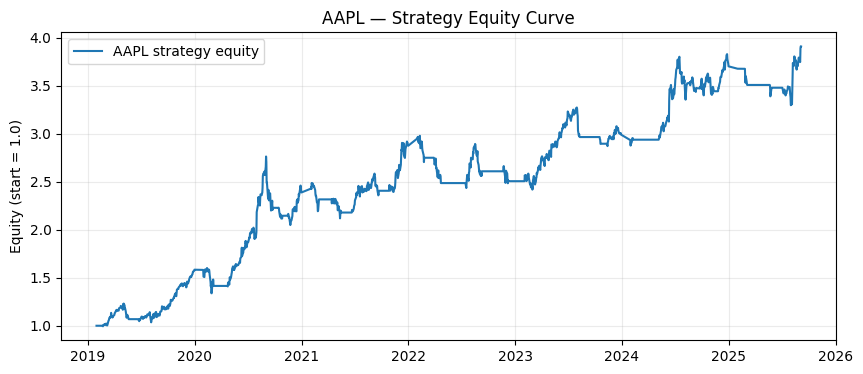

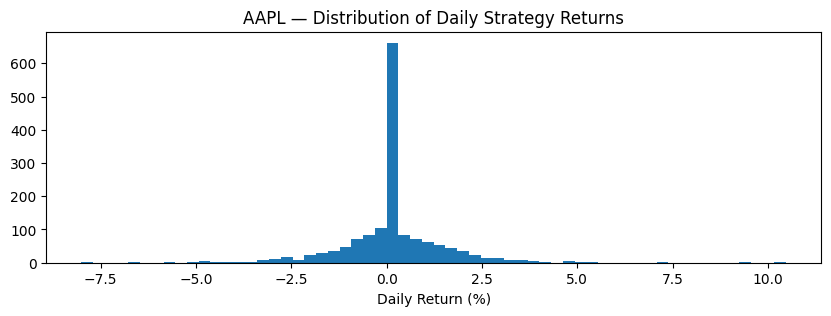

In [12]:
import matplotlib.pyplot as plt

# Pick a ticker to eyeball
tkr = per_ticker["ticker"].iloc[0] if not per_ticker.empty else None
if tkr is None:
    print("[WARN] No data to plot.")
else:
    d = per_ticker.query("ticker == @tkr").sort_values("date").copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d["date"], d["equity"], label=f"{tkr} strategy equity")
    ax.set_title(f"{tkr} — Strategy Equity Curve")
    ax.set_ylabel("Equity (start = 1.0)")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(100*d["ret_strat"].dropna(), bins=60)
    ax.set_title(f"{tkr} — Distribution of Daily Strategy Returns")
    ax.set_xlabel("Daily Return (%)")
    plt.show()


# Step 4 - Power BI Hook (notes)


**Power BI data sources for Week 4 pages**
- `lake/signals_mart.parquet`
- `lake/backtest_mart/_summary.parquet`  (table of per-ticker metrics)
- `lake/backtest_mart/*.parquet`         (per-ticker daily equity/position)

These are ready for visuals like:
- Page A: Signals (sma10 vs sma50, long_rule) + price
- Page B: Strategy equity curve + distribution
- Page C: Summary table (CAGR, Sharpe, Max DD) plus normalized comparisons


# Troubleshooting Notes


- If `feature_mart.parquet` is missing, re-run the Week 3 notebook to regenerate it.
- If Parquet write fails, install pyarrow:
  `pip install pyarrow`
- If you want different thresholds, edit `VOL_HIGH_THRESHOLD` or window sizes at the top and rerun.


In [14]:
# --- PATH DISCOVERY (run once at top of the notebook) ---
from pathlib import Path

def find_repo_root():
    here = Path.cwd()
    for cand in [here, here.parent, here.parent.parent]:
        if (cand / "lake").exists():
            return cand
    raise FileNotFoundError(
        "Couldn't find a 'lake' folder in ., .., or ...\n"
        "Open the notebook from your repo, or create the 'lake' folder at the repo root."
    )

REPO_ROOT   = find_repo_root()
LAKE_ROOT   = REPO_ROOT / "lake"
FEATURE_MART = LAKE_ROOT / "feature_mart.parquet"
SIGNALS_MART = LAKE_ROOT / "signals_mart.parquet"
BACKTEST_DIR = LAKE_ROOT / "backtest_mart"
SUMMARY_FILE = BACKTEST_DIR / "_summary.parquet"

print("Repo root:    ", REPO_ROOT.resolve())
print("Feature mart: ", FEATURE_MART.resolve())
print("Signals mart: ", SIGNALS_MART.resolve())
print("Backtest dir: ", BACKTEST_DIR.resolve())
print("Summary file: ", SUMMARY_FILE.resolve())


Repo root:     C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS
Feature mart:  C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\feature_mart.parquet
Signals mart:  C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\signals_mart.parquet
Backtest dir:  C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\backtest_mart
Summary file:  C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\lake\backtest_mart\_summary.parquet


In [15]:
import pandas as pd
print("exists(feature):", FEATURE_MART.exists())
print("exists(signals):", SIGNALS_MART.exists())
print("exists(backtest dir):", BACKTEST_DIR.exists())
print("exists(summary):", SUMMARY_FILE.exists())

if SIGNALS_MART.exists():
    s = pd.read_parquet(SIGNALS_MART)
    print("signals rows:", len(s), "| tickers:", s["ticker"].nunique(),
          "| dates:", s["date"].min(), "→", s["date"].max())
    display(s.head(3))

if SUMMARY_FILE.exists():
    display(pd.read_parquet(SUMMARY_FILE))


exists(feature): True
exists(signals): True
exists(backtest dir): True
exists(summary): True
signals rows: 6184 | tickers: 4 | dates: 2019-01-30 00:00:00 → 2025-09-05 00:00:00


,date,ticker,close,return1,sma10,vol20,sma50,regime_high_vol,cross_up,long_rule,exit_rule,cross_up_i,long_rule_i
0,2019-01-30,AAPL,39.319290,0.068335,37.154769,1.080499,NaN,False,False,False,True,0,0
1,2019-01-31,AAPL,39.602455,0.007202,37.428399,1.254337,NaN,False,False,False,True,0,0
2,2019-02-01,AAPL,39.621479,0.000480,37.682042,1.241548,NaN,False,False,False,True,0,0


,ticker,start,end,days,CAGR %,Sharpe,Max DD %,Win rate %,Avg daily %,Last Close
0,AAPL,2019-01-30,2025-09-05,2410,22.95,1.17,-25.84,34.48,0.097,239.69
1,MSFT,2019-01-30,2025-09-05,2410,10.89,0.66,-24.13,36.55,0.052,495.00
2,NVDA,2019-01-30,2025-09-05,2410,41.12,1.11,-39.73,37.84,0.179,167.02
3,TSLA,2019-01-30,2025-09-05,2410,31.54,0.90,-56.85,24.64,0.154,350.84
